# How to recover a known planet in Kepler data?

This tutorial demonstrates the basic steps required to recover a transiting planet candidate in the Kepler data.

We will show how you can recover the signal of [Kepler-10b](https://en.wikipedia.org/wiki/Kepler-10b), the first rocky planet that was discovered by Kepler!

In [1]:
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile("Kepler-10", quarter=3).download()
tpf.shape

(4140, 10, 11)

Let's use the `plot` method and pass along an aperture mask and a few plotting arguments.

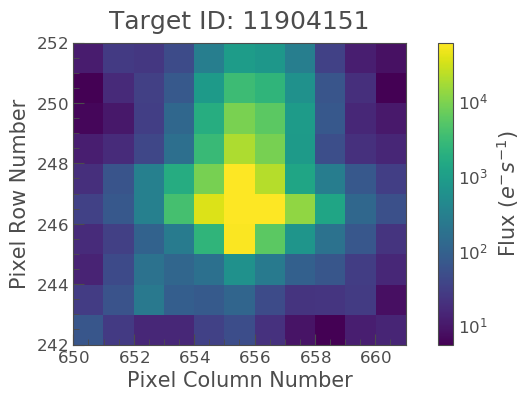

In [2]:
tpf.plot(scale='log');

The target pixel file contains one bright star with approximately 50,000 counts.

Now, we will use the ``to_lightcurve`` method to create a simple aperture photometry lightcurve using the
mask defined by the pipeline which is stored in `tpf.pipeline_mask`.

In [3]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Let's take a look at the output lightcurve.

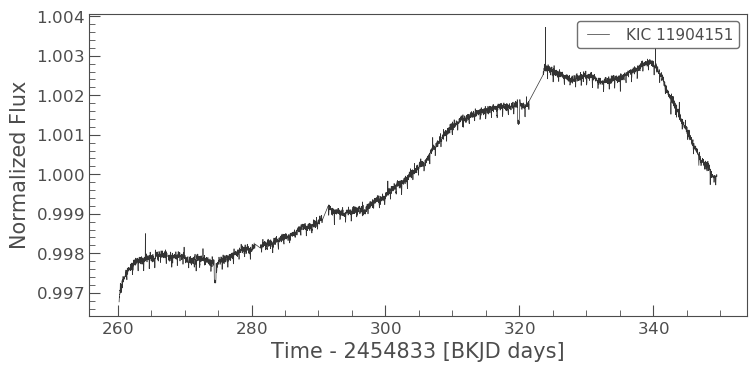

In [4]:
lc.plot();

Now let's use the `flatten` method, removes long-term variability that we are not interested in.

In [5]:
flat, trend = lc.flatten(window_length=301, return_trend=True)

Let's plot the trend estimated by the Savitzky-Golay filter:

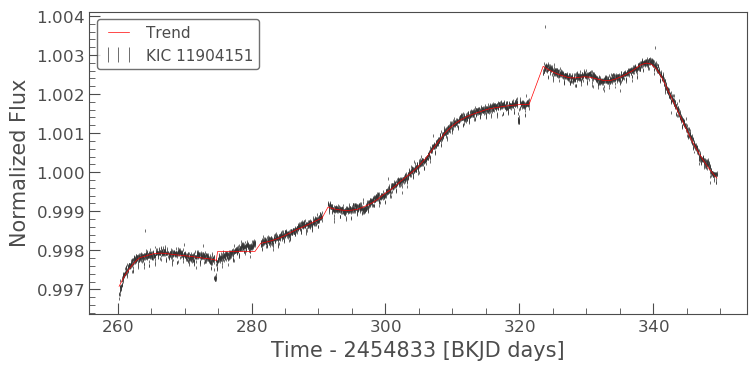

In [6]:
ax = lc.errorbar()                              # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', label='Trend');  # which we can pass to the next plot() to use the same axes

and the flat lightcurve:

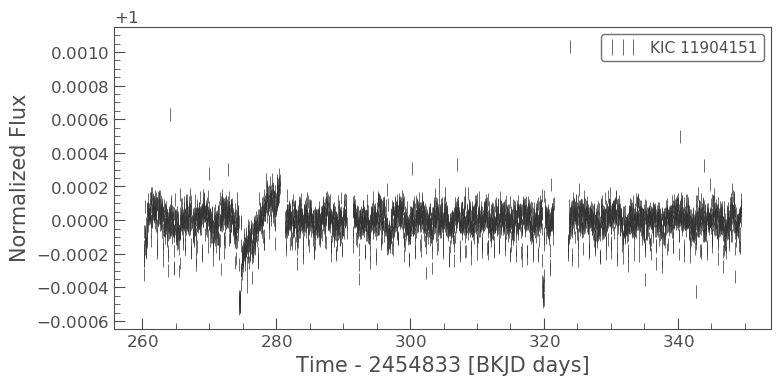

In [7]:
flat.errorbar();

Now, let's run a period search function using the [Box-Least Squares algorithm](http://docs.astropy.org/en/latest/stats/bls.html), which was added to the [AstroPy package](http://docs.astropy.org) in version 3.1.

In [8]:
from astropy.stats import BoxLeastSquares
bls = BoxLeastSquares(flat.time, flat.flux, flat.flux_err)

We will use the BLS algorithm to search a pre-defined grid of transit periods and durations:

In [9]:
import numpy as np
periods = np.arange(0.3, 1.5, 0.001)
durations = np.arange(0.005, 0.15, 0.001)
periodogram = bls.power(periods, durations)  

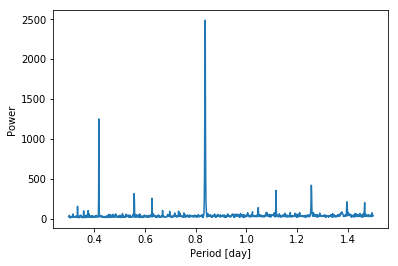

In [10]:
import matplotlib.pyplot as plt
plt.plot(periodogram.period, periodogram.power)
plt.ylabel("Power")
plt.xlabel("Period [day]");

In [11]:
best_fit = periods[np.argmax(periodogram.power)]
print('Best Fit Period: {:0.4f} days'.format(best_fit))

Best Fit Period: 0.8380 days


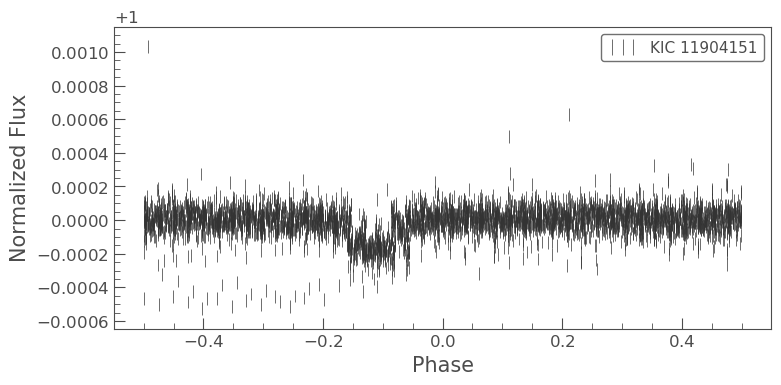

In [12]:
flat.fold(best_fit).errorbar();

We successfully recovered the planet!